# IMDB Sentiment Analysis with Glove's pre-trained word embeddings

## Name: Rafael Gonçalves

### Imports

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style
import torch
import tqdm
import time
from torch import nn
from torch.utils.data import Dataset, RandomSampler, DataLoader
import torchtext
from torchtext.vocab import GloVe
from multiprocessing import cpu_count
from google.colab import drive
import os

### Helper functions

In [0]:
def reproducible(seed=0):
  """Make code in reproducible using a seed for pseudorandomicity."""
  seed = 0
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed_all(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  return seed

In [0]:
def use_cuda():
  """Use GPU acceleration if possible."""
  if torch.cuda.is_available():
    dev = "cuda:0"
  else:
    dev = "cpu"
  return(dev)

In [0]:
def mpl_style(style='ggplot', figsize=(10, 7.5)):
  matplotlib.style.use(style)
  plt.rcParams['figure.figsize'] = figsize

In [0]:
def config():
  """Basic notebook configuration."""
  global device, nproc, base_dir

  # Reproducibility
  if REPRODUCIBLE:
    seed = reproducible()
    print(f'Reproducible code (seed = {seed})')

  # GPU acceleration
  if USE_CUDA:
    dev = use_cuda()
  else:
    dev = 'cpu'
  device = torch.device(dev) 
  print(f'Using device: {device}')

  # CPU cores
  nproc = cpu_count()
  print(f'Using cpu with {nproc} cores')

  # Plot style
  mpl_style()

  # GDrive
  if MOUNT_DRIVE:
    path = '/content/drive'
    drive.mount(path)
    base_dir = os.path.join('/content/drive/My Drive/', 'Colab Notebooks/IA376/')
    print(f'Basedir in {base_dir}')

### Download Dataset

In [6]:
!wget -nc http://files.fast.ai/data/examples/imdb_sample.tgz
!tar -xzf imdb_sample.tgz

File ‘imdb_sample.tgz’ already there; not retrieving.



In [7]:
df = pd.read_csv('imdb_sample/texts.csv')
df.head()

label                                               text  is_valid
0  negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1  positive  This is a extremely well-made film. The acting...     False
2  negative  Every once in a long while a movie will come a...     False
3  positive  Name just says it all. I watched this movie wi...     False
4  negative  This movie succeeds at being one of the most u...     False

In [8]:
df_train = df[df['is_valid'] == False]
df_val = df[df['is_valid'] == True]
print("Train data:", df_train.shape)
print("Validation data:", df_val.shape)

Train data: (800, 3)
Validation data: (200, 3)


In [9]:
df_train

label                                               text  is_valid
0    negative  Un-bleeping-believable! Meg Ryan doesn't even ...     False
1    positive  This is a extremely well-made film. The acting...     False
2    negative  Every once in a long while a movie will come a...     False
3    positive  Name just says it all. I watched this movie wi...     False
4    negative  This movie succeeds at being one of the most u...     False
..        ...                                                ...       ...
795  negative  The ghost of the Vietnam war has haunted the A...     False
796  negative  Thin story concerns two small town brothers an...     False
797  positive  Not everything is said in this excellent first...     False
798  negative  This is just horrible, really horrible trash. ...     False
799  negative  I don't often go out of my way to write commen...     False

[800 rows x 3 columns]

## Create datasets

In [0]:
corpus_train = df_train['text']
corpus_val = df_val['text']

y_train = [1 if (e == 'positive') else 0 for e in df_train['label'].to_numpy()]
y_val = [1 if (e == 'positive') else 0 for e in df_val['label'].to_numpy()]

In [0]:
class SentimentAnalysisTextDataset(Dataset):
    """IMDB sentiment analysis dataset."""
    def __init__(self, corpus, labels, vocab):
        self.tokens = [sample.split() for sample in corpus]
        self.x = [torch.Tensor([vocab[word] for word in sample if word in vocab.keys()]).type(torch.long)
                  for sample in self.tokens]
        self.y = torch.Tensor(labels).type(torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.x[idx], self.y[idx])

In [0]:
def collate(batch):
  texts = []
  offsets = [0]
  targets = []

  for e in batch:
    texts.extend([word for word in e[0]])
    offsets.append(offsets[-1] + len(e[0]))
    targets.append(e[1])
  offsets.pop()

  return ((torch.Tensor(texts).type(torch.long),
          torch.Tensor(offsets).type(torch.long)),
          torch.Tensor(targets).type(torch.long))

## Implementation

In [13]:
REPRODUCIBLE = True
USE_CUDA = False
MOUNT_DRIVE = True

config()

Reproducible code (seed = 0)
Using device: cpu
Using cpu with 2 cores
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Basedir in /content/drive/My Drive/Colab Notebooks/IA376/


## GloVe

In [0]:
dataset_path = os.path.join(base_dir, 'data')
glove_dir = os.path.join(dataset_path, 'glove_dir')

In [0]:
glove_vectors = GloVe(name='6B', dim=300, cache=glove_dir)

In [16]:
print(glove_vectors.vectors.shape)
print('Primeiras 20 palavras e seus índices:', list(glove_vectors.stoi.items())[:20])

torch.Size([400000, 300])
Primeiras 20 palavras e seus índices: [('the', 0), (',', 1), ('.', 2), ('of', 3), ('to', 4), ('and', 5), ('in', 6), ('a', 7), ('"', 8), ("'s", 9), ('for', 10), ('-', 11), ('that', 12), ('on', 13), ('is', 14), ('was', 15), ('said', 16), ('with', 17), ('he', 18), ('as', 19)]


In [17]:
vocab = glove_vectors.stoi
vocab_rev = glove_vectors.itos
vectors = glove_vectors.vectors
len(vocab.items()), vectors.shape

(400000, torch.Size([400000, 300]))

In [18]:
train_dataset = SentimentAnalysisTextDataset(corpus_train, y_train, vocab)
val_dataset = SentimentAnalysisTextDataset(corpus_val, y_val, vocab)
len(train_dataset), len(val_dataset)

(800, 200)

### MLP Model

In [0]:
class PreTrainedModel(nn.Module):
  def __init__(self, hidden_neurons_list, out_features=2, reduction_mode='mean',
               activation=nn.Tanh(), trainable=False, embeddings=vectors):
    super(PreTrainedModel, self).__init__()
    vocab_size, embedding_dim = embeddings.size()
    hidden_neurons_list = [embedding_dim, *hidden_neurons_list, out_features]

    # Embedding layer
    self.embedding = nn.EmbeddingBag(vocab_size, embedding_dim, mode=reduction_mode)

    # Activation
    self.activation = activation

    # Dense layers
    self.layers = nn.ModuleList([nn.Linear(e, f) for e, f in 
                                 zip(hidden_neurons_list, hidden_neurons_list[1:])])
    
    # Pre-trained embedding
    self.embedding.load_state_dict({'weight': vectors})
    self.embedding.weight.requires_grad = trainable

  def forward(self, inputs, offsets=torch.Tensor([0]).type(torch.long)):
    offsets=offsets.to(device)
    x = self.embedding(inputs, offsets)
    for layer in self.layers[:-1]:
      x = layer(x)
      x = self.activation(x)
    x = self.layers[-1](x)
    return x

In [20]:
model = PreTrainedModel([100]).to(device); model

PreTrainedModel(
  (embedding): EmbeddingBag(400000, 300, mode=mean)
  (activation): Tanh()
  (layers): ModuleList(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=2, bias=True)
  )
)

In [21]:
[x.size() for x in model.parameters()], sum([torch.tensor(x.size()).prod() for x in model.parameters()])

([torch.Size([400000, 300]),
  torch.Size([100, 300]),
  torch.Size([100]),
  torch.Size([2, 100]),
  torch.Size([2])],
 tensor(120030302))

In [22]:
a, b = train_dataset.__getitem__(torch.tensor(1))
a.size(), b

(torch.Size([292]), tensor(1))

In [23]:
texts, y_hat = train_dataset.__getitem__(torch.tensor(1))
y = model(texts); y

tensor([[ 0.0593, -0.0099]], grad_fn=<AddmmBackward>)

In [0]:
class EarlyStopping():
    """Early stopping training class. Based on: https://rguigoures.github.io/word2vec_pytorch/"""
    def __init__(self, patience=5, min_percent_gain=0.1):
        self.patience = patience
        self.loss_list = []
        self.min_percent_gain = min_percent_gain / 100.
        
    def update_loss(self, loss):
        self.loss_list.append(loss)
        if len(self.loss_list) > self.patience:
            del self.loss_list[0]
    
    def stop_training(self):
        if len(self.loss_list) == 1:
            return False
        gain = (max(self.loss_list) - min(self.loss_list)) / max(self.loss_list)
        if gain < self.min_percent_gain:
            return True
        else:
            return False

In [0]:
def train_eval_loop(model, optimizer, max_epochs=10, patience=5,
                    min_percent_gain=0.1, criterion=nn.CrossEntropyLoss()):
  """Perform model training-evaluating loop using early stopping and max epochs as
  stopping criterions."""

  early_stopping = EarlyStopping(patience, min_percent_gain)
  stop = False
  train_loss_l = []
  test_loss_l = []
  test_acc_l = []
  counter = 0
  epoch = 0

  while (not stop and epoch < max_epochs):
  
    phases = ['train', 'test']

    for phase in phases:
      if phase == 'train':
        model.train()
        train_losses = []

        for batch_idx, (data, target) in enumerate(train_loader):
          texts, offsets = data[0].to(device), data[1].to(device)
          target = target.to(device)
          y_logits = model(texts, offsets)
          loss = criterion(y_logits, target)
          # Backpropagation
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          #Logging
          train_losses.append(loss.item())

        train_loss_l.append(np.mean(train_losses))

      if phase == 'test':
        model.eval()
        test_losses = []
        correct = 0

        for data, target in test_loader:
          texts, offsets = data[0].to(device), data[1].to(device)
          target = target.to(device)
          with torch.no_grad():
            y_logits = model(texts, offsets)
            loss = criterion(y_logits, target)
          test_losses.append(loss.item())
          pred = torch.argmax(y_logits, dim=-1)
          correct += (pred == target).type(torch.float).sum().item()

        test_loss_l.append(np.mean(test_losses))
        test_acc_l.append(correct/float(len(test_loader.dataset)))
        early_stopping.update_loss(np.mean(train_losses))
        epoch += 1

        if early_stopping.stop_training():
          stop = True

  return train_loss_l, test_loss_l, test_acc_l

## Hyperparameters

In [0]:
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=True,
                          num_workers=nproc, pin_memory=True, collate_fn=collate)
test_loader = DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False,
                          num_workers=nproc, pin_memory=True, collate_fn=collate)

In [0]:
# Hyperparameters
hidden_layers_params = [[], [10], [50], [50, 10], [50, 50]]
reduction_params = ['mean', 'max', 'sum']
learning_rate_params = [0.0001, 0.001, 0.01, 0.1]
momentum_params = [0, 0.9]
max_epochs = 100
patience = 3

In [0]:
models = {"index": [], "hidden layers": [], "reduction": [], "learning rate": [],
          "momentum": [], "epoch": [], "loss": [], "acc": []}
lc_train_l = []
lc_val_l = []
lc_acc_l = []

In [29]:
tk0 = tqdm.notebook.trange(len(hidden_layers_params)*len(reduction_params), desc='Models')
idx = 0
for hidden_layers in hidden_layers_params:
  for reduction in reduction_params:
    idx += 1

    model = PreTrainedModel(hidden_layers, reduction_mode=reduction).to(device)
    best_loss = 999

    tk1 = tqdm.notebook.trange(len(learning_rate_params)*len(momentum_params),
                              desc=f'Train model {idx}')

    for lr in learning_rate_params:
      for momentum in momentum_params:
        opt = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum)

        loss_train, loss_val, acc_l = train_eval_loop(model, opt, max_epochs, patience)

        if np.min(loss_val) < best_loss:
          best_loss = np.min(loss_val)
          best = [lr, momentum, np.argmin(loss_val), np.min(loss_val),
                  np.max(acc_l), loss_train, loss_val, acc_l]

        tk1.set_postfix(loss=best_loss)
        tk1.update()

    models["index"].append(idx)
    models["hidden layers"].append(hidden_layers)
    models["reduction"].append(reduction)
    models["learning rate"].append(best[0])
    models["momentum"].append(best[1])
    models["epoch"].append(best[2])
    models["loss"].append(best[3])
    models["acc"].append(4)
    lc_train_l.append(best[5])
    lc_val_l.append(best[6])
    lc_acc_l.append(best[7])
    tk0.update()

In [30]:
pd.DataFrame(models, index=models['index'])

index hidden layers reduction  learning rate  momentum  epoch      loss  acc
1      1            []      mean           0.10       0.0     97  0.455929    4
2      2          [10]      mean           0.01       0.9     55  0.455331    4
3      3          [50]      mean           0.10       0.9     12  0.453255    4
4      4      [50, 10]      mean           0.01       0.9     28  0.455980    4
5      5      [50, 50]      mean           0.01       0.9     34  0.454279    4

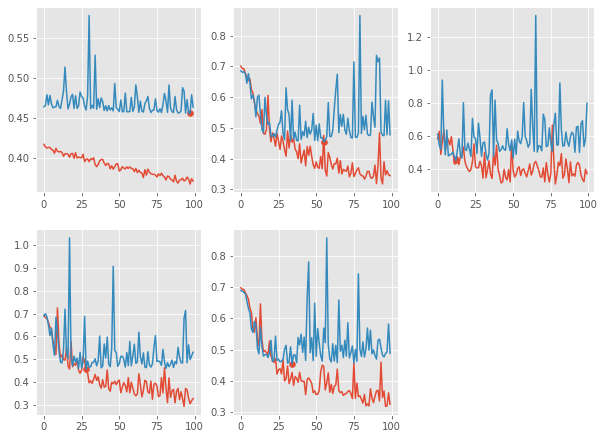

In [31]:
import math
n_rows = math.ceil(len(models['index'])/3)

for i in models['index']:
  plt.subplot(n_rows, 3, i)
  plt.plot(lc_train_l[i-1])
  plt.plot(lc_val_l[i-1])
  plt.scatter(models['epoch'][i-1], models['loss'][i-1])
plt.show()

In [0]:
best_model = PreTrainedModel([50]).to(device)
best_opt = torch.optim.SGD(best_model.parameters(), lr=0.1, momentum=0.9)

patience=10
max_epochs=200

loss_train, loss_val, acc_l = train_eval_loop(best_model, best_opt, max_epochs, patience)

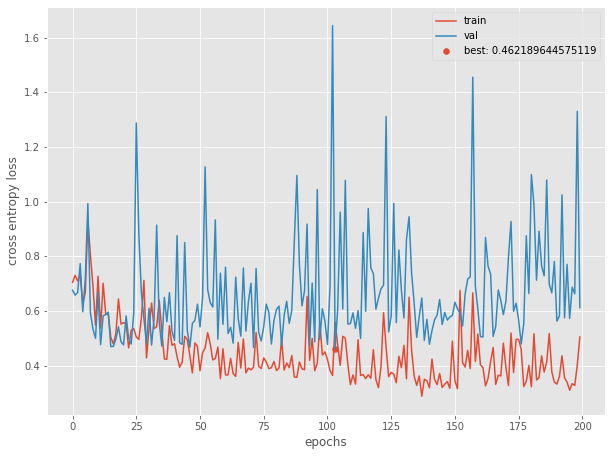

In [37]:
plt.plot(loss_train)
plt.plot(loss_val)
plt.scatter(np.argmin(loss_val), np.min(loss_val))
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.legend(['train', 'val', 'best: {}'.format(np.min(loss_val))])
plt.show()

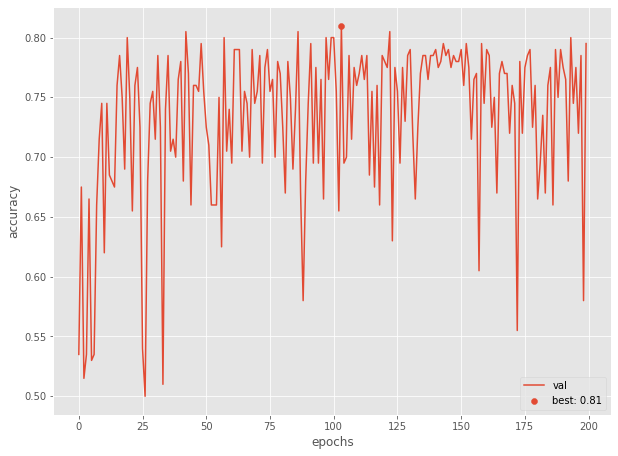

In [38]:
plt.plot(acc_l)
plt.scatter(np.argmax(acc_l), np.max(acc_l))
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['val', 'best: {}'.format(np.max(acc_l))])
plt.show()

# End of notebook